In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

We have generated the cross-validation folds. We now need to choose a model. <br>
The criteria are test-set performance and feature stability. <br>
We'll use logistic regression as baseline and compare with decision trees (random forest) and their gradient-boosted version (cat-boost)

We first need to encode the categorical variables. <br>
TBMK, this is required of all models except cat-boost. <br>
There was also one column('RISK_RATED_AREA_C') with 5% of values missing in our pre-processed set. All the tree based methods impute these values: LR does not -> we'll impute median for now<br>  

# Encode categorical values

In [2]:
def is_categorical_variable(values):
    is_cat=False
    first_valid_index=values.first_valid_index()
    if type(values[first_valid_index]) == str:
        is_cat=True
    return is_cat    

def get_categorical_columns(df):
    is_cat=[is_categorical_variable(df[col]) for col in df.columns]
    categoricals=list(filter(lambda x: x[1], zip(df.columns, is_cat)))
    cat_columns=[val[0] for val in categoricals]
    return cat_columns

def encode_categorical_values(df):
    cat_columns=get_categorical_columns(df)
    for col in cat_columns:
        df[col] = df[col].astype("category").cat.codes +1
    return df

Impute missing values (hacky)

In [3]:
def impute_missing_values(df, col):
    median=np.median(df[~df[col].isnull()][col])
    df[col]=df[col].fillna(median)
    return df

Normalize all values (hacky)

In [4]:
scaler = MinMaxScaler(feature_range = (0,1))

## Get the train-test data and fit the model

In [5]:
def get_train_test_sets(df, use_scaler=True):
    X_train=df[df['is_test'] == 0].drop(['is_lapsed', 'is_test'], axis=1).copy()
    X_test=df[df['is_test'] == 1].drop(['is_lapsed', 'is_test'], axis=1).copy()
    y_train=df[df['is_test'] == 0]['is_lapsed'].copy()
    y_test=df[df['is_test'] == 1]['is_lapsed'].copy()
    feature_cols=X_train.columns
    if use_scaler:
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    #print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    return X_train, y_train, X_test, y_test, feature_cols

## Create test-set scores - no parameter tuning    

In [6]:
def setup_classifier(X_train, y_train, classifier='lr', balance=False, balance_random_state=2, lrwt=0.225):
    
    if classifier == 'RF':
        if balance:
            clf = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt', 
                                         class_weight='balanced')
        else:    
            clf = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')
    elif classifier == 'XGB':
        if balance:
            clf = xgb.XGBClassifier(max_depth=10, min_child_weight=1,  n_estimators=100,\
                          n_jobs=-1 , verbose=1,learning_rate=0.16, scale_pos_weight=3, use_label_encoder=False)
        else:
            clf = xgb.XGBClassifier(max_depth=10, min_child_weight=1,  n_estimators=100,\
                          n_jobs=-1 , verbose=1,learning_rate=0.16, use_label_encoder=False)
    else:
        if balance:
            weights={0:lrwt, 1:1.0}
            clf = LogisticRegression(solver = 'liblinear', class_weight=weights)
        else:
            clf = LogisticRegression(solver = 'liblinear')
    
    clf.fit(X_train, y_train)
        
    return clf


def get_feature_importance(cl_flag, clf, feature_col_names, is_plot=True, num_features_to_display=5):
    
    if cl_flag == 'RF':
        imp = clf.feature_importances_
    elif cl_flag == 'XGB':
        imp = clf.feature_importances_
    else: #LR
        imp = clf.coef_[0]
    
    if is_plot:
        tup=list(zip(imp, feature_col_names, abs(imp)))
        sorted_list=sorted(tup, key=lambda x: x[2], reverse=True)
        labels=[x[1] for x in sorted_list]
        values=[x[0] for x in sorted_list]
        return labels, values
    else:
        tup=list(zip(imp, feature_col_names, abs(imp)))
        sorted_list=sorted(tup, key=lambda x: x[2], reverse=True)
        features=[x[1] for x in sorted_list][:num_features_to_display]
        return features
    

def get_classifier_scores(clf, X_test, y_test, cl_flag, feature_col_names, num_features=5):
    
    classes = clf.predict(X_test)
    #accuracy = metrics.accuracy_score(classes, y_test)
    #balanced_accuracy = metrics.balanced_accuracy_score(classes, y_test)
    precision = metrics.precision_score(classes, y_test)
    #average_precision = metrics.average_precision_score(classes, y_test)
    recall = metrics.recall_score(classes, y_test)
    f1_score = metrics.f1_score(classes, y_test)
    roc_auc = metrics.roc_auc_score(classes, y_test)
    top_features=get_feature_importance(cl_flag, clf, feature_col_names, is_plot=False, 
                                        num_features_to_display=num_features)
    
    dic={'AUC': round(roc_auc,2), 'Precision': round(precision,2), 'Recall': round(recall,2), 
         'F1 score': round(f1_score,2), 'Top n features': top_features}
    
    return dic




## Generate performance grids

In [7]:
def performance_grid(X_train, y_train, X_test, y_test, feature_col_names, classifier_label, balance_classes):
    
    clf=setup_classifier(X_train, y_train, classifier_label, balance_classes)
    scores= get_classifier_scores(clf, X_test, y_test, classifier_label, feature_col_names)
    return scores

def generate_model_performance_grid(dfs_in, index_labels, classifier_label='LR', balance_classes=True, 
                     use_scaler=True, impute_missing=True):
    dfs=[encode_categorical_values(df_in) for df_in in dfs_in]
    if impute_missing:
        dfs=[impute_missing_values(df, 'RISK_RATED_AREA_C') for df in dfs] #hard-coded the only feature w mssg values
    perfs=[]
    for df in dfs:
        X_train, y_train, X_test, y_test, feature_col_names=get_train_test_sets(df, use_scaler)
        perf=performance_grid(X_train, y_train, X_test, y_test, feature_col_names, classifier_label, balance_classes)
        perfs.append(perf)
    df_perf=pd.DataFrame(perfs, index_labels)
    return df_perf

In [8]:
base_path=os.getcwd()+"\\data\\folds\\"
file_names=os.listdir(base_path)
labels=[x.split(".")[0] for x in file_names]
file_paths=[base_path+x for x in file_names]
dfs_in=[pd.read_csv(path) for path in file_paths]

In [9]:
classifier_labels=['LR', 'RF', 'XGB']
balance_classes=[True, True, True] 
use_scaler=[True, False, False]
impute_missing=[True, False, False]

In [10]:
df_perfs=[generate_model_performance_grid(dfs_in, labels, clf, bal, scale, impute) for clf, bal, scale, impute 
          in zip(classifier_labels, balance_classes, use_scaler, impute_missing)]          

[14:13:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:13:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:13:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used bu

In [11]:
pd.set_option('display.max_colwidth', None)

### Logistic Regression

In [19]:
df_perfs[0]['model']="LR"
df_perfs[0]

,AUC,Precision,Recall,F1 score,Top n features,model
2008,0.60,0.83,0.33,0.48,"[RISK_RATED_AREA_C, LEGAL_ADDON_POST_REN, HP3_ADDON_POST_REN, LEGAL_ADDON_PRE_REN, HP1_ADDON_POST_REN]",LR
2009,0.60,0.90,0.32,0.48,"[RISK_RATED_AREA_C, LEGAL_ADDON_POST_REN, HP3_ADDON_POST_REN, LEGAL_ADDON_PRE_REN, HP1_ADDON_POST_REN]",LR
2010,0.62,0.93,0.38,0.54,"[RISK_RATED_AREA_C, LEGAL_ADDON_POST_REN, HP3_ADDON_POST_REN, LEGAL_ADDON_PRE_REN, HP1_ADDON_POST_REN]",LR
2011,0.64,0.95,0.41,0.57,"[RISK_RATED_AREA_C, LEGAL_ADDON_POST_REN, HP3_ADDON_POST_REN, LEGAL_ADDON_PRE_REN, SPEC_SUM_INSURED]",LR


### Random Forest

In [20]:
df_perfs[1]['model']="RF"
df_perfs[1]

,AUC,Precision,Recall,F1 score,Top n features,model
2008,0.75,0.22,0.73,0.34,"[LAST_ANN_PREM_GROSS, RISK_RATED_AREA_C, age_at_cover_start, cover_start_year, P1_MAR_STATUS]",RF
2009,0.71,0.18,0.67,0.28,"[LAST_ANN_PREM_GROSS, age_at_cover_start, RISK_RATED_AREA_C, cover_start_year, P1_MAR_STATUS]",RF
2010,0.69,0.16,0.69,0.27,"[LAST_ANN_PREM_GROSS, age_at_cover_start, RISK_RATED_AREA_C, cover_start_year, P1_MAR_STATUS]",RF
2011,0.68,0.14,0.70,0.23,"[LAST_ANN_PREM_GROSS, age_at_cover_start, RISK_RATED_AREA_C, cover_start_year, PROP_TYPE]",RF


# XG Boost

In [21]:
df_perfs[2]['model']="XGB"
df_perfs[2]

,AUC,Precision,Recall,F1 score,Top n features,model
2008,0.62,0.60,0.42,0.49,"[LEGAL_ADDON_PRE_REN, LEGAL_ADDON_POST_REN, P1_MAR_STATUS, PAYMENT_METHOD, HP1_ADDON_POST_REN]",XGB
2009,0.60,0.63,0.39,0.49,"[LEGAL_ADDON_PRE_REN, LEGAL_ADDON_POST_REN, P1_MAR_STATUS, PAYMENT_METHOD, HP1_ADDON_POST_REN]",XGB
2010,0.62,0.70,0.46,0.55,"[LEGAL_ADDON_PRE_REN, LEGAL_ADDON_POST_REN, PAYMENT_METHOD, P1_MAR_STATUS, KEYCARE_ADDON_PRE_REN]",XGB
2011,0.65,0.76,0.50,0.61,"[LEGAL_ADDON_PRE_REN, PAYMENT_METHOD, LEGAL_ADDON_POST_REN, P1_MAR_STATUS, AD_BUILDINGS]",XGB


While RF has higher AUCs (trending down to LR and XGB levels though), Precision is really low suggesting that it is less 
able to identify potential lapses. <br>
LR and XGB have fewer false positives (better able to target potential lapses). <br>
Though XGB has a slightly higher F1 score, I would go with LR owing to the simplicity of implementation and stability of top features <br>
More work on scaler, missing value imputation could improve performance of LR. <br>
By the same token, more work on hyperparameter tuning could improve XGBoost

## Visualize results: accuracy metrics

In [22]:
df_all_perfs=pd.concat(df_perfs)
df_all_perfs.tail()

,AUC,Precision,Recall,F1 score,Top n features,model
2011,0.68,0.14,0.70,0.23,"[LAST_ANN_PREM_GROSS, age_at_cover_start, RISK_RATED_AREA_C, cover_start_year, PROP_TYPE]",RF
2008,0.62,0.60,0.42,0.49,"[LEGAL_ADDON_PRE_REN, LEGAL_ADDON_POST_REN, P1_MAR_STATUS, PAYMENT_METHOD, HP1_ADDON_POST_REN]",XGB
2009,0.60,0.63,0.39,0.49,"[LEGAL_ADDON_PRE_REN, LEGAL_ADDON_POST_REN, P1_MAR_STATUS, PAYMENT_METHOD, HP1_ADDON_POST_REN]",XGB
2010,0.62,0.70,0.46,0.55,"[LEGAL_ADDON_PRE_REN, LEGAL_ADDON_POST_REN, PAYMENT_METHOD, P1_MAR_STATUS, KEYCARE_ADDON_PRE_REN]",XGB
2011,0.65,0.76,0.50,0.61,"[LEGAL_ADDON_PRE_REN, PAYMENT_METHOD, LEGAL_ADDON_POST_REN, P1_MAR_STATUS, AD_BUILDINGS]",XGB


In [38]:
def get_grouped_bar_chart(metric):
    
    #create the metric data frame
    cols2choose=['model', metric]
    df_metric=df_all_perfs[cols2choose].copy()
    
    #create the pivot table
    df_pivot = pd.pivot_table(df_metric, values=metric, index=df_metric.index, columns="model")
    
    #plot the bar chart
    ax = df_pivot.plot(kind="bar")
    
    # Get a Matplotlib figure from the axes object for formatting purposes
    fig = ax.get_figure()
    
    # Change the plot dimensions (width, height)
    fig.set_size_inches(7, 6)
    
    # Change the axes labels
    ax.set_xlabel("Years")
    ax.set_ylabel(metric)
    
    fig.suptitle(metric, fontsize=16)

[None, None, None, None]

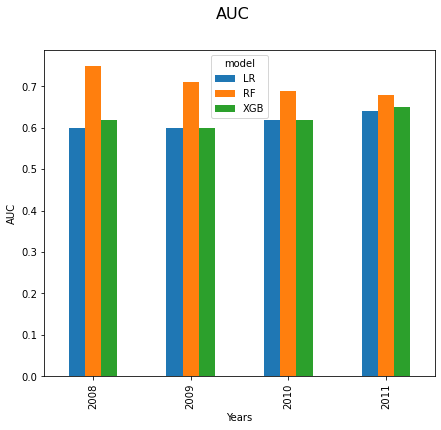

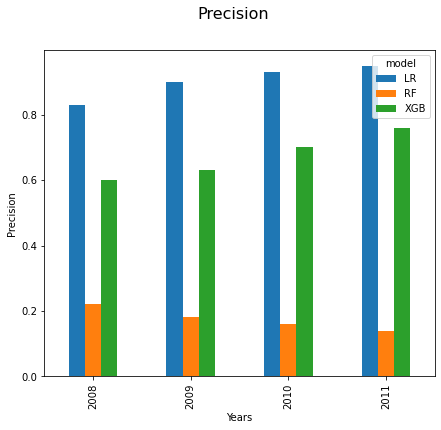

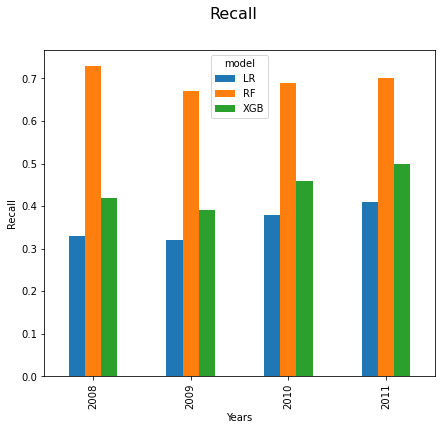

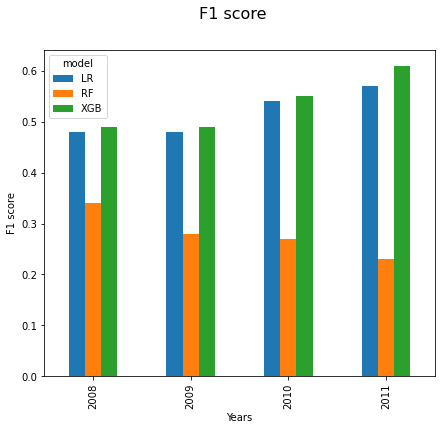

In [39]:
metrics=['AUC', 'Precision', 'Recall', 'F1 score']
charts=[get_grouped_bar_chart(metric) for metric in metrics]
charts